In [1]:
import gc
import os
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

In [2]:
os.listdir('../input')

['test_identity.csv',
 'sample_submission.csv',
 'train_identity.csv',
 'train_transaction.csv',
 'test_transaction.csv']

In [3]:
df_train = pd.read_csv('../input/train_transaction.csv')
df_train_i = pd.read_csv('../input/train_identity.csv')
df_test = pd.read_csv('../input/test_transaction.csv')
df_test_i = pd.read_csv('../input/test_identity.csv')

In [4]:
df_train = df_train.merge(df_train_i, how='left', left_index=True, right_index=True)
df_test = df_test.merge(df_test_i, how='left', left_index=True, right_index=True)

In [5]:
print("df_train shape :", df_train.shape)
print("df_test shape :", df_test.shape)

df_train shape : (590540, 435)
df_test shape : (506691, 434)


In [6]:
features = [c for c in df_train.columns if c not in ['TransactionID', 'isFraud']]

In [7]:
target = df_train['isFraud']
df_train = df_train.drop('isFraud', axis=1)

In [8]:
categorical_feats = list()
for f in features:
    if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[f].values) + list(df_test[f].values))
        df_train[f] = le.transform(list(df_train[f].values))
        df_test[f] = le.transform(list(df_test[f].values))
        categorical_feats.append(f)

In [9]:
param = {'num_leaves': 64,
         'min_data_in_leaf': 63, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8,
         "bagging_seed": 5,
         "metric": 'auc',
         "verbosity": -1,
         "random_state": 2019}

In [10]:
folds = KFold(n_splits=5, shuffle=False, random_state=2019)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval= 100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

fold 0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.895212	valid_1's auc: 0.858418
[200]	training's auc: 0.914113	valid_1's auc: 0.872056
[300]	training's auc: 0.928976	valid_1's auc: 0.881399
[400]	training's auc: 0.939981	valid_1's auc: 0.890807
[500]	training's auc: 0.948441	valid_1's auc: 0.89817
[600]	training's auc: 0.954731	valid_1's auc: 0.902746
[700]	training's auc: 0.959433	valid_1's auc: 0.905436
[800]	training's auc: 0.96309	valid_1's auc: 0.907967
[900]	training's auc: 0.966021	valid_1's auc: 0.909461
[1000]	training's auc: 0.968633	valid_1's auc: 0.910683
[1100]	training's auc: 0.970832	valid_1's auc: 0.911657
[1200]	training's auc: 0.972832	valid_1's auc: 0.912389
[1300]	training's auc: 0.974602	valid_1's auc: 0.912713
[1400]	training's auc: 0.976267	valid_1's auc: 0.912818
[1500]	training's auc: 0.977716	valid_1's auc: 0.912885
[1600]	training's auc: 0.979085	valid_1's auc: 0.913048
[1700]	training's auc: 0.980372	valid_1's auc: 0.913

In [11]:
##plot the feature importance
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

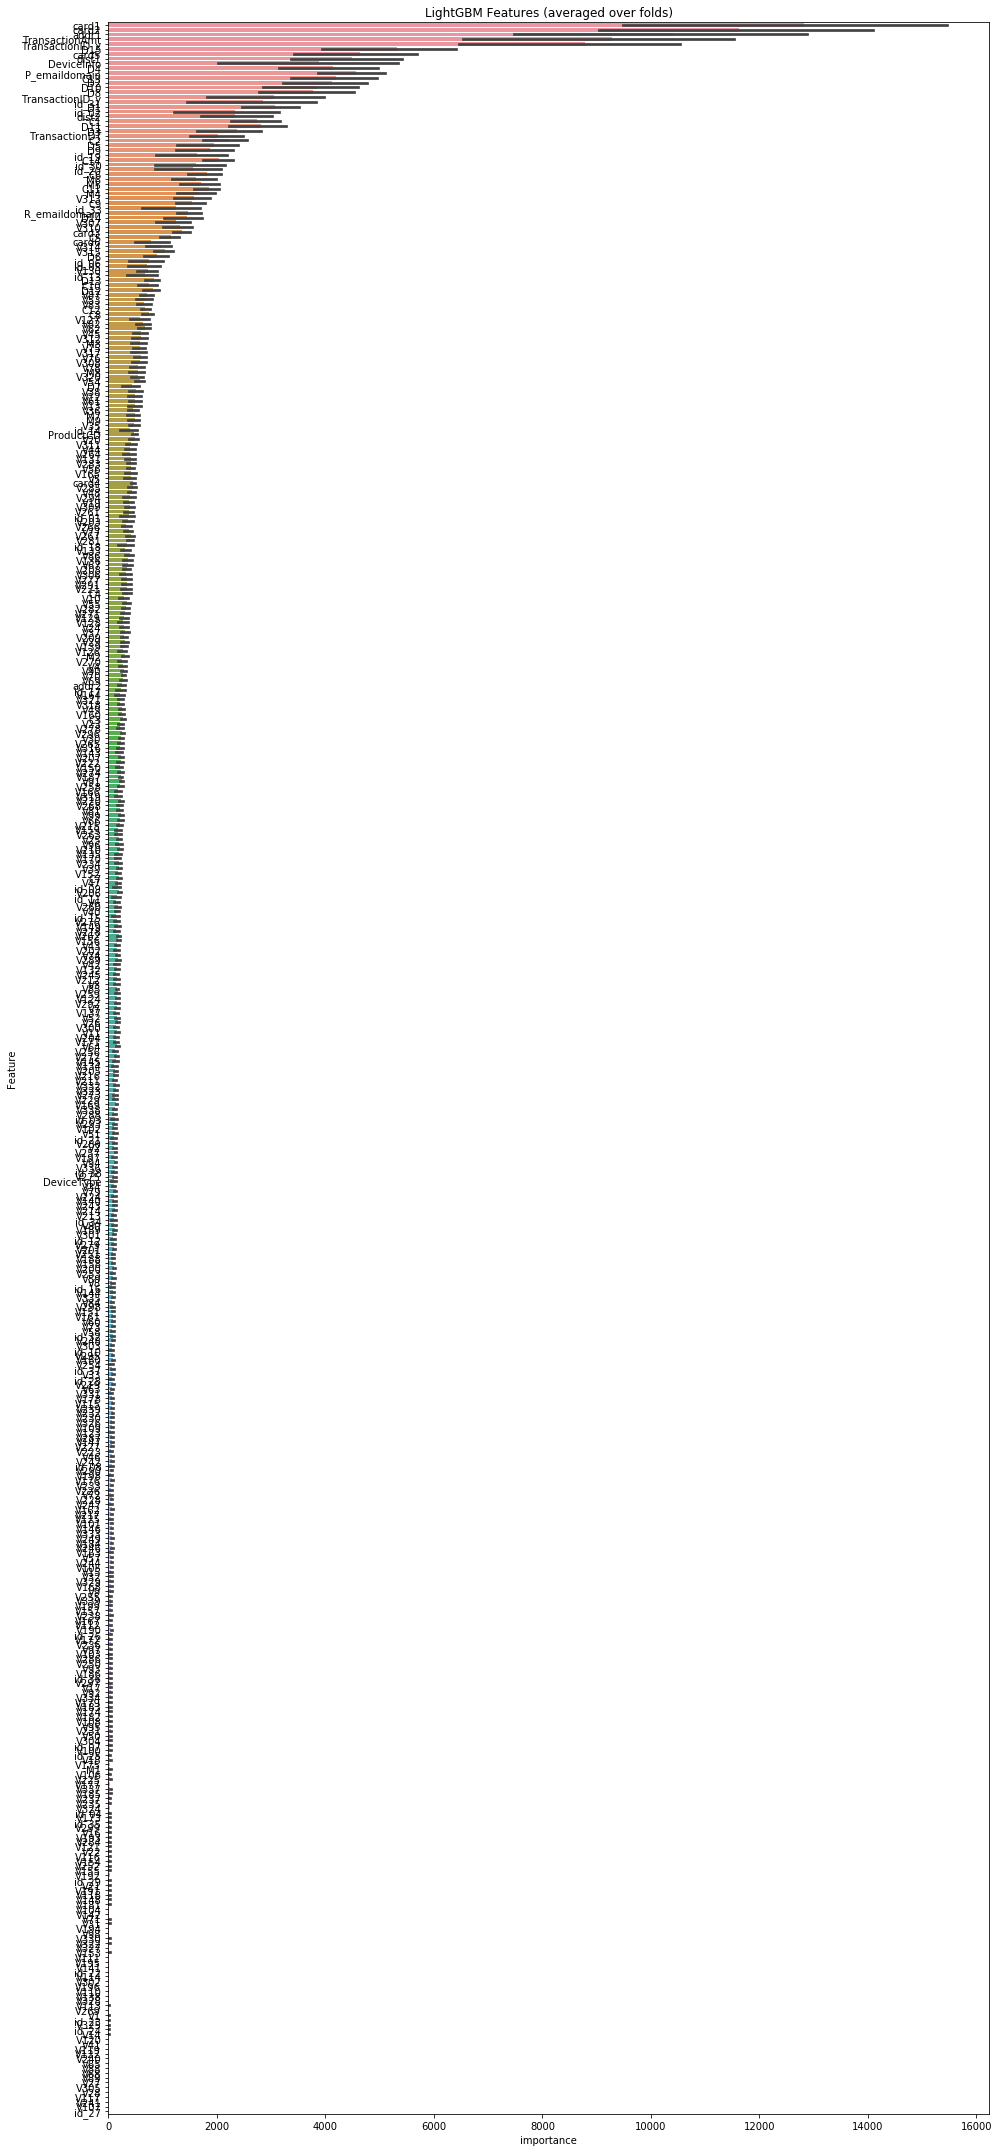

In [12]:
##lgbm_importance
plt.figure(figsize=(14,30))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [13]:
##submission
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['isFraud'] = predictions
sample_submission.to_csv('submission.csv', index=False)